In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
import tensorflow as tf

def SepConvBN(x, filters, kernel_size, dilation_rate=1):
    x = DepthwiseConv2D(kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1,1), padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def ASPP(x, filters=64):
    shape = K.int_shape(x)

    b1 = Conv2D(filters, (1,1), padding='same')(x)
    b1 = BatchNormalization()(b1)
    b1 = ReLU()(b1)

    b2 = SepConvBN(x, filters, 3, dilation_rate=2)
    b3 = SepConvBN(x, filters, 3, dilation_rate=4)
    b4 = SepConvBN(x, filters, 3, dilation_rate=6)

    # global pooling
    b6 = GlobalAveragePooling2D()(x)
    b6 = Reshape((1,1,shape[-1]))(b6)
    b6 = Conv2D(filters, (1,1), padding='same')(b6)
    b6 = BatchNormalization()(b6)
    b6 = ReLU()(b6)
    b6 = UpSampling2D(size=(shape[1],shape[2]), interpolation='bilinear')(b6)

    x = Concatenate()([b1, b2, b3, b4, b6])
    x = Conv2D(filters, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x
def ChannelAttention(x, ratio=8):
    filters = x.shape[-1]

    avg = GlobalAveragePooling2D()(x)
    avg = Dense(filters//ratio, activation='relu')(avg)
    avg = Dense(filters)(avg)

    mx = GlobalMaxPooling2D()(x)
    mx = Dense(filters//ratio, activation='relu')(mx)
    mx = Dense(filters)(mx)

    att = Add()([avg, mx])
    att = Activation("sigmoid")(att)
    att = Reshape((1,1,filters))(att)
    return Multiply()([x, att])

def SpatialAttention(x):
    avg = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(x)
    mx  = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(x)
    concat = Concatenate()([avg, mx])
    att = Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat)
    return Multiply()([x, att])

def CBAM(x):
    x = ChannelAttention(x)
    x = SpatialAttention(x)
    return x
def RESBLK(x, filters=None):
    if filters is None:
        filters = x.shape[-1]

    bottleneck = filters // 4

    skip = x

    x = Conv2D(bottleneck, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, skip])
    x = ReLU()(x)
    return x
def fcn(x, num_classes):
    x = GlobalAveragePooling2D()(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Dropout(0.3)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Dense(num_classes, activation='softmax')(x)

    return x


def livernet(input_shape=(224,224,3), num_classes=4):

    inp = Input(shape=input_shape)

    x = Conv2D(32, 3, strides=2, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.003))(inp)
    x = BatchNormalization()(x)

    x = Conv2D(32, 3, strides=2, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    A1 = ASPP(x, 64)

    x = Conv2D(64, 3, strides=2, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = BatchNormalization()(x)

    x = CBAM(x)
    x = RESBLK(x)

    x = MaxPooling2D()(x)
    A2 = ASPP(x, 64)

    x = Conv2D(64, 3, strides=2, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = BatchNormalization()(x)

    x = CBAM(x)
    x = RESBLK(x)

    x = MaxPooling2D()(x)
    A3 = ASPP(x, 64)
    # bi3 = UpSampling2D(size=(8,8))(A3)
    target_h = tf.shape(A3)[1]
    target_w = tf.shape(A3)[2]
    
    bi1 = tf.image.resize(A1, (target_h, target_w), method='bilinear')
    bi2 = tf.image.resize(A2, (target_h, target_w), method='bilinear')
    bi3 = A3
    
    concat = Concatenate(axis=-1)([bi1, bi2, bi3])

    out = fcn(concat, num_classes)

    return Model(inp, out)


model =livernet()
model.summary()

    


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_371 (Conv2D)             (None, 112, 112, 32) 896         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_494 (BatchN (None, 112, 112, 32) 128         conv2d_371[0][0]                 
__________________________________________________________________________________________________
conv2d_372 (Conv2D)             (None, 56, 56, 32)   9248        batch_normalization_494[0][0]    
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_delta=0.0001
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


check_path = '/content/drive/MyDrive/Liver Colon.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)


hist_scratch =model.fit(
    train_generator,
    validation_data=val_generator, 
    epochs=65,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/65
417/417 [==============================] - 229s 538ms/step - loss: 2.8910 - accuracy: 0.5511 - val_loss: 3.5255 - val_accuracy: 0.4499

Epoch 00001: val_accuracy improved from -inf to 0.44995, saving model to /content/drive/MyDrive\Liver Colon.weights.h5
Epoch 2/65
417/417 [==============================] - 64s 153ms/step - loss: 2.6252 - accuracy: 0.6246 - val_loss: 2.4868 - val_accuracy: 0.6606

Epoch 00002: val_accuracy improved from 0.44995 to 0.66058, saving model to /content/drive/MyDrive\Liver Colon.weights.h5
Epoch 3/65
417/417 [==============================] - 63s 150ms/step - loss: 2.4576 - accuracy: 0.6356 - val_loss: 2.3711 - val_accuracy: 0.6465

Epoch 00003: val_accuracy did not improve from 0.66058
Epoch 4/65
417/417 [==============================] - 63s 151ms/step - loss: 2.3049 - accuracy: 0.6461 - val_loss: 2.2493 - val_accuracy: 0.6538

Epoch 00004: val_accuracy did not improve from 0.66058
Epoch 5/65
417/417 [==============================] - 63s 152ms/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0, 0.5, 'Loss')

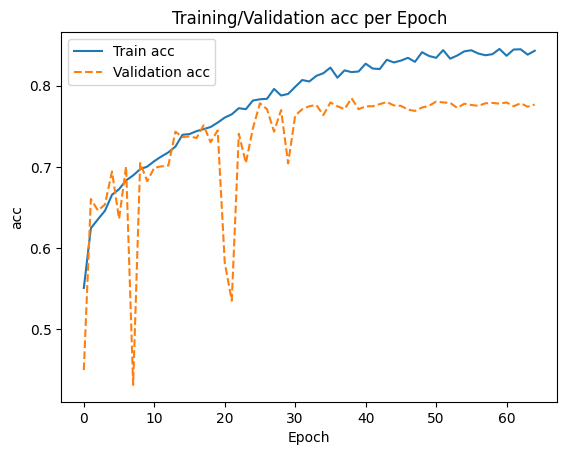

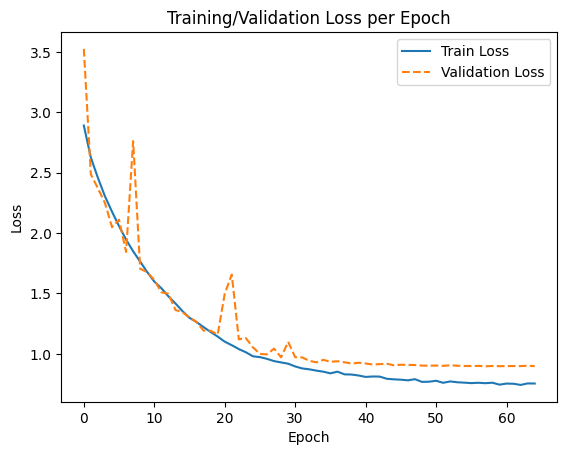

In [ ]:
print(hist_scratch.history.keys())

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['accuracy'])
ax.plot(hist_scratch.history['val_accuracy'], '--')
ax.legend(['Train acc', 'Validation acc'])
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['loss'], )
ax.plot(hist_scratch.history['val_loss'], '--')
ax.legend(['Train Loss', 'Validation Loss'])
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [23]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'A': 0, 'B': 1, 'C': 2, 'D': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[0 0 0 ... 2 3 3]


In [24]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.8043310131477185
F1 0.7813963138021734
precision 0.7776590088028528
recall 0.7868445460386067
jaccard 0.6538320420172968
classification_report
               precision    recall  f1-score   support

           0       0.99      0.91      0.95       466
           1       0.66      0.68      0.67       233
           2       0.74      0.75      0.74       411
           3       0.73      0.80      0.76       183

    accuracy                           0.80      1293
   macro avg       0.78      0.79      0.78      1293
weighted avg       0.81      0.80      0.81      1293




[[426  10   6  24]
 [  2 158  73   0]
 [  2  69 309  31]
 [  2   2  32 147]]
